In [ ]:
  %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim


In [ ]:
# Open data from URL using pandas
url = 'https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv' 

df = pd.read_csv(url)
 
# This is what the data looks like 
print(df)


      pruid                  prname  ... avgdeaths_last7 avgratedeaths_last7
0        35                 Ontario  ...             NaN                 NaN
1        59        British Columbia  ...             NaN                 NaN
2         1                  Canada  ...             NaN                 NaN
3        35                 Ontario  ...             NaN                 NaN
4        59        British Columbia  ...             NaN                 NaN
...     ...                     ...  ...             ...                 ...
5947     60                   Yukon  ...             0.0                0.00
5948     61   Northwest Territories  ...             0.0                0.00
5949     62                 Nunavut  ...             0.0                0.00
5950     99  Repatriated travellers  ...             0.0                 NaN
5951      1                  Canada  ...            31.0                0.08

[5952 rows x 39 columns]


In [ ]:
# Extract data for BC 
D = df["prname"]
A = df.loc[df['prname'] == "British Columbia"]
print(A.columns)


Index(['pruid', 'prname', 'prnameFR', 'date', 'update', 'numconf', 'numprob',
       'numdeaths', 'numtotal', 'numtested', 'numtests', 'numrecover',
       'percentrecover', 'ratetested', 'ratetests', 'numtoday', 'percentoday',
       'ratetotal', 'ratedeaths', 'numdeathstoday', 'percentdeath',
       'numtestedtoday', 'numteststoday', 'numrecoveredtoday', 'percentactive',
       'numactive', 'rateactive', 'numtotal_last14', 'ratetotal_last14',
       'numdeaths_last14', 'ratedeaths_last14', 'numtotal_last7',
       'ratetotal_last7', 'numdeaths_last7', 'ratedeaths_last7',
       'avgtotal_last7', 'avgincidence_last7', 'avgdeaths_last7',
       'avgratedeaths_last7'],
      dtype='object')


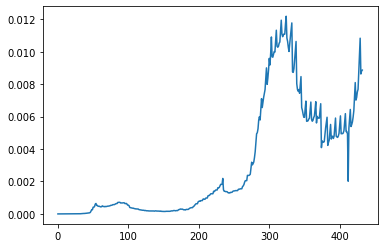

In [ ]:
# Take the date column
T = A.date
# Convert it to dtype date
T = pd.to_datetime(T)
# Make it day number
base_date = T.min()
t = T.map(lambda date : (pd.Timestamp(date) - base_date).days )

# get the number of confirmed cases per day 
Iobs = pd.to_numeric(A.numactive)

t = t.to_numpy()
Iobs = Iobs.to_numpy()
# Normalize S relative to exposed BC pop
Iobs = Iobs/1e6
# plot the number of active cases
plt.plot(t,Iobs)


In [ ]:
def SEIRmodel(S0,E0,I0,beta,gamma,mu,a,n,dt):

  SS = torch.zeros(n+1,dtype=torch.float32)
  II = torch.zeros(n+1,dtype=torch.float32)
  EE = torch.zeros(n+1,dtype=torch.float32)
  t = torch.zeros(n+1,dtype=torch.float32)
  
  beta = torch.relu(beta)
  S = S0
  I = I0
  E = E0
  SS[0] = 1.0*S
  II[0] = 1.0*I
  EE[0] = 1.0*E
  
  for i in range(1,n+1):
    # S[i+1] - S[i] = dt*(mu*N - mu*S - beta*S*I). (Assume N=1)
    # E[i+1] - E[i] = dt*beta*S*I - dt*(mu+a)*E
    # I[i+1] - I[i] = dt*a*E - dt*(mu+gamma)*I
    Sold = S
    Eold = E
    S = S - dt*beta[i-1]*S*I + dt*mu*(1.0 - S)
    E = E + dt*beta[i-1]*Sold*I - dt*(mu+a)*Eold
    I = I + dt*a*Eold - dt*(mu+gamma)*I
    t[i]  = t[i-1] + dt
    SS[i] = S
    II[i] = I
    EE[i] = E
    
  return SS, II, EE, t

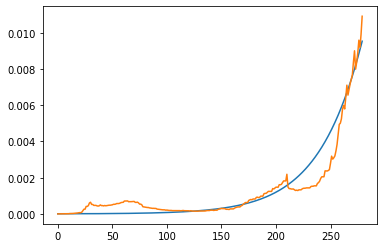

In [ ]:
S0 = 0.99998
E0 = 0.00001
I0 = 0.00001
n  = Iobs.shape[0]

beta  = 0.8*torch.ones(n,dtype=torch.float32)
gamma = 0.0015
mu    = 0.00001
a     = 0.00105
dt    = 1.0

Sc, Ic, Ec, tc = SEIRmodel(S0,E0,I0,beta,gamma,mu,a,n,dt)
plt.plot(tc[:280],Ic[:280].detach(),tc[:280],Iobs[:280])
#plt.plot(tc[:280],Ic[:280].detach())


In [ ]:
#beta  = 0.8*torch.ones(n,dtype=torch.float32)
gamma = 0.0015
mu    = 0.00001
a     = 0.00105
dt    = 1.0
numiter = 10

# Make the data torch variable
Iobs = torch.tensor(Iobs,dtype=torch.float32)
N = torch.numel(Iobs)-1
# step size (for gradient descent)
delta      = 1e-3

numiter = 10000

for i in range(numiter):
    #  compute function and its gradient
    I0 = Iobs[0]
    S0 =  1.0-I0
    
    # Make beta a parameter that we can compute gradients 
    beta = torch.tensor(beta, requires_grad=True)
    # Evaluate the objective function
    Sc, Ic, Ec, tc = SEIRmodel(S0,E0,I0,beta,gamma,mu,a,N,dt)
    # loss = torch.norm(Ic-Iobs)**2/torch.norm(Iobs)**2
    loss = F.mse_loss(Ic,Iobs)/F.mse_loss(Iobs*0,Iobs)
    
    # Compute gradients
    loss.backward()
    gradLoss = beta.grad
    # update the parameters
    with torch.no_grad():
      beta -= delta*gradLoss
      
      
    if i%100==1:
      print(i, loss.item(), torch.norm(gradLoss).item())
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1 0.6269992589950562 0.06165774166584015
101 0.6266237497329712 0.060931842774152756
201 0.6262565851211548 0.06021888926625252
301 0.6258983016014099 0.05952029302716255
401 0.625548243522644 0.05883466452360153
501 0.6252056360244751 0.05816081538796425
601 0.6248713731765747 0.05750066041946411
701 0.6245447397232056 0.056853048503398895
801 0.6242247223854065 0.05621643364429474
901 0.6239120364189148 0.05559169873595238
1001 0.6236063241958618 0.05497853457927704
1101 0.6233074069023132 0.05437715724110603
1201 0.6230149269104004 0.05378663167357445
1301 0.6227290630340576 0.05320759117603302
1401 0.6224486231803894 0.05263777822256088
1501 0.6221747994422913 0.05207977816462517
1601 0.6219063401222229 0.05153103172779083
1701 0.6216437220573425 0.05099257826805115
1801 0.6213863492012024 0.050463784486055374
1901 0.6211342215538025 0.049944497644901276
2001 0.620887279510498 0.04943424090743065
2101 0.6206454038619995 0.04893366992473602
2201 0.6204083561897278 0.0484417676925659

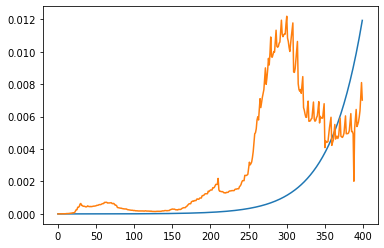

In [ ]:
plt.plot(tc[:400],Ic[:400].detach(),tc[:400],Iobs[:400])
